In [14]:
import pandas as pd
import os
import yaml # Necesario para leer archivos .dvc (YAML)
import mlflow
import mlflow.data
import mlflow.sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# --- CAMBIO CLAVE 1: Importar RandomForestClassifier (y eliminar GradientBoostingClassifier) ---
from sklearn.ensemble import RandomForestClassifier 

# --- IMPORTACIONES DE MÉTRICAS (Sin cambios) ---
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# --- CONFIGURACIÓN DE RUTAS (Sin cambios) ---
DATASET_PATH = '../data/interim/student_interim_clean.csv' 
DATASET_NAME = 'student_entry_clean'

# --- 1. CARGA DE DATOS (Sin cambios) ---
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset cargado desde: {DATASET_PATH}")
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en {DATASET_PATH}. Revisa la ruta.")
    exit()

# --- 2. LÓGICA DVC: OBTENER EL HASH (Sin cambios) ---
dvc_digest = None
dvc_file_path = DATASET_PATH + ".dvc"
if os.path.exists(dvc_file_path):
    try:
        with open(dvc_file_path, 'r') as f:
            dvc_data = yaml.safe_load(f)
        if 'outs' in dvc_data and dvc_data['outs']:
            dvc_digest = dvc_data['outs'][0].get('md5') 
            if not dvc_digest:
                dvc_digest = dvc_data['outs'][0].get('checksum') 
        print(f"DVC Digest encontrado: {dvc_digest}")
    except Exception as e:
        print(f"ADVERTENCIA: No se pudo leer el archivo DVC. Error: {e}")

# --- 3. PREPARACIÓN DE DATOS Y SPLIT (Sin cambios) ---
X = df.drop(columns=['Performance']) 
y = df['Performance']
cat_cols = ['Gender','Caste','coaching','time','Class_ten_education','twelve_education','medium','Class_ X_Percentage','Class_XII_Percentage','Father_occupation','Mother_occupation']

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


# ---------------------------------------------------------------------
# --- 4. CONFIGURACIÓN DEL PIPELINE BASE Y LA GRILLA DE BÚSQUEDA ---
# ---------------------------------------------------------------------

# Pipeline base (usando RandomForestClassifier)
preprocessor = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='drop'
)
# --- CAMBIO 2: Usar RandomForestClassifier ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=888))
])

# --- CAMBIO 3: Definimos la Grilla de Parámetros para RandomForestClassifier (¡Diferente!) ---
param_grid = {
    'clf__n_estimators': [15,20,25],    # Cantidad de árboles
    'clf__max_depth': [5, 10,20],       # Profundidad máxima
    'clf__min_samples_split': [10, 15,20]      # Muestras mínimas para dividir
}

#clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 20

# Configuración del Grid Search (Sin cambios)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted', 
    cv=5,                   
    verbose=2,
    n_jobs=1
)

# --- 5. ENTRENAMIENTO Y PREDICCIONES (Ejecución del Grid Search) ---
print("\nIniciando Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search finalizado.")


# ---------------------------------------------------------------------
# --- 6. REGISTRO DE TODAS LAS CORRIDAS EN MLFLOW ---
# ---------------------------------------------------------------------

mlflow.set_tracking_uri("http://127.0.0.1:5001")
# --- CAMBIO 4: Nuevo nombre de experimento para RandomForest ---
EXPERIMENT_NAME = "randomforest_GridSearch" 
mlflow.set_experiment(EXPERIMENT_NAME)


# Iterar sobre CADA resultado de CV (Cross-Validation)
for i, (mean_score, std_score, params) in enumerate(zip(
    grid_search.cv_results_['mean_test_score'],
    grid_search.cv_results_['std_test_score'],
    grid_search.cv_results_['params']
)):
    
    # --- CAMBIO 5: Actualizar el nombre de la corrida a RF ---
    with mlflow.start_run(run_name=f"run_{i+1}_RF_GridSearch", nested=True) as run:
        print(f"Registrando corrida {i+1} con parámetros: {params}")

        # La limpieza de parámetros es la misma
        clf_params = {k.replace('clf__', ''): v for k, v in params.items()}
        
        # --- CAMBIO 6: Reconstruir el pipeline con RandomForestClassifier ---
        current_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('clf', RandomForestClassifier(random_state=888, **clf_params)) 
        ])
        
        # Entrenar el modelo con el conjunto de entrenamiento COMPLETO
        current_pipeline.fit(X_train, y_train)
        
        # --- Predicciones y Cálculo de Métricas (en el conjunto de prueba) ---
        y_pred_test = current_pipeline.predict(X_test)
        
        # Calcular Métricas (Sin cambios)
        acc_test = accuracy_score(y_test, y_pred_test)
        f1_micro = f1_score(y_test, y_pred_test, average='micro')
        f1_macro = f1_score(y_test, y_pred_test, average='macro')
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
        report_text = classification_report(y_test, y_pred_test, target_names=le.classes_)
        
        metrics = {
            "cv_f1_weighted_mean": mean_score, 
            "cv_f1_weighted_std": std_score,
            "test_acc": acc_test,
            "test_f1_weighted": f1_weighted,
            "test_f1_macro": f1_macro,
        }
        
        # --- Registro en MLflow (Sin cambios sustanciales) ---
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        
        # Guardar modelo (artefacto)
        mlflow.sklearn.log_model(current_pipeline, "random_forest_pipeline") # Nombre de artefacto actualizado
        
        # Registrar Dataset (Sin cambios)
        mlflow_dataset = mlflow.data.from_pandas(
            df=df, source=DATASET_PATH, targets=y.name, name=DATASET_NAME, digest=dvc_digest)
        mlflow.log_input(mlflow_dataset, context="training") 

        # Registrar Classification Report (Sin cambios)
        temp_report_path = f"classification_report_run_{i+1}.txt"
        with open(temp_report_path, "w") as f:
            f.write(report_text)
        mlflow.log_artifact(temp_report_path, artifact_path="report")
        os.remove(temp_report_path)

        # Identificación del Mejor Modelo (Sin cambios)
        if mean_score == grid_search.best_score_:
              print(f"!!! Este es el mejor modelo (F1-Weighted CV: {mean_score:.4f}) !!!")
              mlflow.set_tag("best_run", "True")


print("\n--- RESUMEN FINAL DE GRID SEARCH ---")
print(f"El mejor F1-Weighted (CV) es: {grid_search.best_score_:.4f}")
print(f"Los mejores parámetros son: {grid_search.best_params_}")

Dataset cargado desde: ../data/interim/student_interim_clean.csv

Iniciando Grid Search...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=15; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=15; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=15; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=15; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=15; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=20; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=20; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=20; total time=   0.0s
[CV] END clf__max_depth=5, clf__min_samples_split=10, clf__n_estimators=20; total time=

c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:153

Registrando corrida 2 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 20}


2025/11/02 21:09:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:10:08 INFO 

Registrando corrida 3 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 25}


2025/11/02 21:10:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:10:28 INFO 

Registrando corrida 4 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__n_estimators': 15}


2025/11/02 21:10:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:10:48 INFO 

Registrando corrida 5 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}


2025/11/02 21:10:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:11:06 INFO 

Registrando corrida 6 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__n_estimators': 25}


2025/11/02 21:11:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:11:25 INFO 

Registrando corrida 7 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 15}


2025/11/02 21:11:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:11:45 INFO 

Registrando corrida 8 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 20}


2025/11/02 21:11:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:12:04 INFO 

Registrando corrida 9 con parámetros: {'clf__max_depth': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 25}


2025/11/02 21:12:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:12:23 INFO 

Registrando corrida 10 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 15}


2025/11/02 21:12:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:12:44 INFO 

Registrando corrida 11 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 20}


2025/11/02 21:12:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:13:08 INFO 

Registrando corrida 12 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 25}


2025/11/02 21:13:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:13:32 INFO 

Registrando corrida 13 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 15, 'clf__n_estimators': 15}


2025/11/02 21:13:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:14:01 INFO 

Registrando corrida 14 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}


2025/11/02 21:14:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:14:41 INFO 

Registrando corrida 15 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 15, 'clf__n_estimators': 25}


2025/11/02 21:14:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:15:04 INFO 

Registrando corrida 16 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 20, 'clf__n_estimators': 15}


2025/11/02 21:15:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:15:25 INFO 

Registrando corrida 17 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 20, 'clf__n_estimators': 20}


2025/11/02 21:15:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:15:48 INFO 

Registrando corrida 18 con parámetros: {'clf__max_depth': 10, 'clf__min_samples_split': 20, 'clf__n_estimators': 25}


2025/11/02 21:15:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:16:07 INFO 

Registrando corrida 19 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 15}


2025/11/02 21:16:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:16:24 INFO 

Registrando corrida 20 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 20}


2025/11/02 21:16:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:16:46 INFO 

Registrando corrida 21 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 25}


2025/11/02 21:16:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:17:09 INFO 

Registrando corrida 22 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 15}


2025/11/02 21:17:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:17:35 INFO 

Registrando corrida 23 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}


2025/11/02 21:17:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:18:12 INFO 

!!! Este es el mejor modelo (F1-Weighted CV: 0.5344) !!!
Registrando corrida 24 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 25}


c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:153

Registrando corrida 25 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 20, 'clf__n_estimators': 15}


2025/11/02 21:18:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:19:28 INFO 

Registrando corrida 26 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 20, 'clf__n_estimators': 20}


2025/11/02 21:19:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:20:06 INFO 

Registrando corrida 27 con parámetros: {'clf__max_depth': 20, 'clf__min_samples_split': 20, 'clf__n_estimators': 25}


2025/11/02 21:20:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/interim/student_interim_clean.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2025/11/02 21:20:42 INFO 


--- RESUMEN FINAL DE GRID SEARCH ---
El mejor F1-Weighted (CV) es: 0.5344
Los mejores parámetros son: {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}


Dataset cargado desde: ../data/interim/student_interim_clean.csv

Entrenando el modelo final con parámetros óptimos...
Entrenamiento finalizado.

     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA
Accuracy (Exactitud): 0.5368
F1-Score (Micro):     0.5368
F1-Score (Macro):     0.3859
F1-Score (Weighted):  0.5182

--------------------------------------------------
REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)
--------------------------------------------------
              precision    recall  f1-score   support

     average       0.65      0.69      0.67        32
   excellent       0.25      0.10      0.14        20
        good       0.44      0.56      0.49        43
        none       0.00      0.00      0.00         1
          vg       0.62      0.62      0.62        40

    accuracy                           0.54       136
   macro avg       0.39      0.39      0.39       136
weighted avg       0.51      0.54      0.52       136


-------------------------------

c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuar\Documents\Maestria Inteligencia artificial\MLOPs Prueba\Cookie cutter 2\proyecto_mlops_equipo_56\.venv\Lib\site-packages\sklearn\metrics\_classification.py:153

<Figure size 800x600 with 0 Axes>

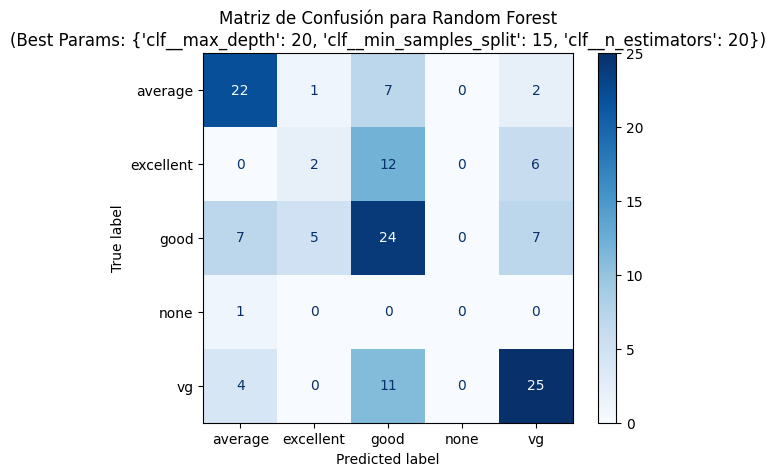

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns # Se necesita para una matriz de confusión visual

# Importaciones de métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay # Se necesita para graficar la matriz
)

# --- CONFIGURACIÓN DE RUTAS Y PARÁMETROS OPTIMOS ---
DATASET_PATH = '../data/interim/student_interim_clean.csv' 

# Parámetros óptimos obtenidos del Grid Search
BEST_PARAMS = {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}
RANDOM_STATE = 888 

# --- 1. CARGA DE DATOS (Necesaria para preparar X y y) ---
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset cargado desde: {DATASET_PATH}")
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en {DATASET_PATH}. Revisa la ruta.")
    exit()

# --- 2. PREPARACIÓN DE DATOS Y SPLIT (DEBE SER IDÉNTICO AL ENTRENAMIENTO) ---
X = df.drop(columns=['Performance']) 
y = df['Performance']
cat_cols = ['Gender','Caste','coaching','time','Class_ten_education','twelve_education','medium','Class_ X_Percentage','Class_XII_Percentage','Father_occupation','Mother_occupation']

le = LabelEncoder()
y_enc = le.fit_transform(y) # y_enc es tu variable objetivo codificada

# Nombres de las clases para el reporte y la matriz
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


# ---------------------------------------------------------------------
# --- 3. RECONSTRUCCIÓN Y ENTRENAMIENTO DEL MEJOR PIPELINE ---
# ---------------------------------------------------------------------

# Preprocesador (IDÉNTICO al del Grid Search)
preprocessor = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='drop'
)

# Obtenemos los parámetros del clasificador
clf_params = {k.replace('clf__', ''): v for k, v in BEST_PARAMS.items()}

# Definimos el Pipeline FINAL usando los parámetros óptimos
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, **clf_params))
])

print("\nEntrenando el modelo final con parámetros óptimos...")
final_pipeline.fit(X_train, y_train)
print("Entrenamiento finalizado.")


# ---------------------------------------------------------------------
# --- 4. EVALUACIÓN DE MÉTRICAS Y MATRIZ DE CONFUSIÓN ---
# ---------------------------------------------------------------------

# Predicciones en el conjunto de prueba
y_pred_test = final_pipeline.predict(X_test)

## 4.1. CÁLCULO DE MÉTRICAS
print("\n" + "="*50)
print("     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*50)

acc_test = accuracy_score(y_test, y_pred_test)
f1_micro = f1_score(y_test, y_pred_test, average='micro')
f1_macro = f1_score(y_test, y_pred_test, average='macro')
f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

print(f"Accuracy (Exactitud): {acc_test:.4f}")
print(f"F1-Score (Micro):     {f1_micro:.4f}")
print(f"F1-Score (Macro):     {f1_macro:.4f}")
print(f"F1-Score (Weighted):  {f1_weighted:.4f}")

# Reporte de clasificación (Precision, Recall, F1 por clase)
print("\n" + "-"*50)
print("REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)")
print("-"*50)
print(classification_report(y_test, y_pred_test, target_names=class_names))


## 4.2. MATRIZ DE CONFUSIÓN
print("\n" + "-"*50)
print("MATRIZ DE CONFUSIÓN")
print("-"*50)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
# Usamos ConfusionMatrixDisplay para una visualización limpia
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Matriz de Confusión para Random Forest\n(Best Params: {BEST_PARAMS})')
plt.show()

In [16]:
# Después de: df = pd.read_csv(DATASET_PATH)
print("\nValores únicos en la columna 'Performance' antes de la codificación:")
print(df['Performance'].value_counts())
print("\nClases detectadas por LabelEncoder:")
print(le.fit(df['Performance']).classes_) # Ajustar y mostrar las clases del LabelEncoder


Valores únicos en la columna 'Performance' antes de la codificación:
Performance
good         213
vg           200
average      158
excellent    102
none           6
Name: count, dtype: int64

Clases detectadas por LabelEncoder:
['average' 'excellent' 'good' 'none' 'vg']


Dataset cargado desde: ../data/interim/student_interim_clean.csv
Filas eliminadas debido a 'Performance' == 'none': 6

Entrenando el modelo final con parámetros óptimos...
Entrenamiento finalizado.

     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA
Accuracy (Exactitud): 0.4444
F1-Score (Micro):     0.4444
F1-Score (Macro):     0.4074
F1-Score (Weighted):  0.4291

--------------------------------------------------
REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)
--------------------------------------------------
              precision    recall  f1-score   support

     average       0.66      0.78      0.71        32
   excellent       0.20      0.10      0.13        20
        good       0.33      0.44      0.38        43
          vg       0.48      0.35      0.41        40

    accuracy                           0.44       135
   macro avg       0.42      0.42      0.41       135
weighted avg       0.43      0.44      0.43       135


--------------------------------

<Figure size 800x600 with 0 Axes>

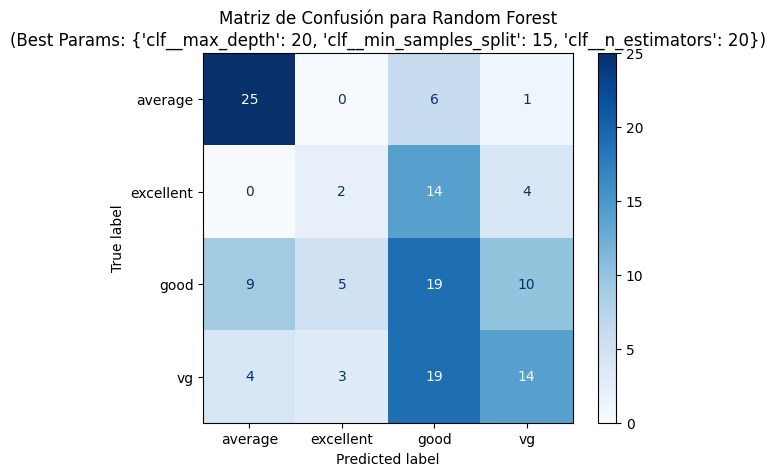

In [17]:
import pandas as pd
import os
import yaml
import numpy as np # Necesario si vas a usar np.nan
import matplotlib.pyplot as plt
import seaborn as sns 

# Importaciones clave de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Importaciones de métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
)

# --- CONFIGURACIÓN DE RUTAS Y PARÁMETROS OPTIMOS ---
DATASET_PATH = '../data/interim/student_interim_clean.csv' 

# Parámetros óptimos obtenidos del Grid Search
BEST_PARAMS = {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}
RANDOM_STATE = 888 

# --- 1. CARGA DE DATOS ---
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset cargado desde: {DATASET_PATH}")
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en {DATASET_PATH}. Revisa la ruta.")
    exit()

# --- CAMBIO AQUÍ: Filtrar o manejar la clase 'none' ---
# Opción 1: Eliminar filas donde 'Performance' es 'none'
# Esta es la forma más sencilla si 'none' son simplemente datos que no quieres modelar.
initial_rows = len(df)
df = df[df['Performance'] != 'none']
# Puedes añadir otras variantes como:
# df['Performance'] = df['Performance'].replace('none', np.nan) # Reemplazar con NaN
# df = df.dropna(subset=['Performance']) # Luego eliminar NaNs de esa columna
# Asegúrate de que 'none' sea el string exacto si es lo que aparece.
print(f"Filas eliminadas debido a 'Performance' == 'none': {initial_rows - len(df)}")


# --- 2. PREPARACIÓN DE DATOS Y SPLIT ---
X = df.drop(columns=['Performance']) 
y = df['Performance']
cat_cols = ['Gender','Caste','coaching','time','Class_ten_education','twelve_education','medium','Class_ X_Percentage','Class_XII_Percentage','Father_occupation','Mother_occupation']

le = LabelEncoder()
y_enc = le.fit_transform(y) # y_enc es tu variable objetivo codificada

# Nombres de las clases para el reporte y la matriz
class_names = le.classes_ # Ahora 'none' no debería estar aquí si se filtró correctamente

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


# ---------------------------------------------------------------------
# --- 3. RECONSTRUCCIÓN Y ENTRENAMIENTO DEL MEJOR PIPELINE (Sin cambios) ---
# ---------------------------------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='drop'
)

clf_params = {k.replace('clf__', ''): v for k, v in BEST_PARAMS.items()}

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, **clf_params))
])

print("\nEntrenando el modelo final con parámetros óptimos...")
final_pipeline.fit(X_train, y_train)
print("Entrenamiento finalizado.")


# ---------------------------------------------------------------------
# --- 4. EVALUACIÓN DE MÉTRICAS Y MATRIZ DE CONFUSIÓN (Sin cambios) ---
# ---------------------------------------------------------------------

y_pred_test = final_pipeline.predict(X_test)

print("\n" + "="*50)
print("     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*50)

acc_test = accuracy_score(y_test, y_pred_test)
f1_micro = f1_score(y_test, y_pred_test, average='micro')
f1_macro = f1_score(y_test, y_pred_test, average='macro')
f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

print(f"Accuracy (Exactitud): {acc_test:.4f}")
print(f"F1-Score (Micro):     {f1_micro:.4f}")
print(f"F1-Score (Macro):     {f1_macro:.4f}")
print(f"F1-Score (Weighted):  {f1_weighted:.4f}")

print("\n" + "-"*50)
print("REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)")
print("-"*50)
print(classification_report(y_test, y_pred_test, target_names=class_names))

print("\n" + "-"*50)
print("MATRIZ DE CONFUSIÓN")
print("-"*50)

cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Matriz de Confusión para Random Forest\n(Best Params: {BEST_PARAMS})')
plt.show()

In [18]:

import pandas as pd
import os
import yaml
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
# --- NUEVAS IMPORTACIONES DE MLFLOW ---
import mlflow
import mlflow.sklearn
# --------------------------------------

# Importaciones clave de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Importaciones de métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
)

# --- CONFIGURACIÓN DE RUTAS Y PARÁMETROS OPTIMOS ---
DATASET_PATH = '../data/interim/student_interim_clean.csv' 
EXPERIMENT_NAME = "randomforest_final_evaluation" # Nombre del nuevo experimento/corrida
RANDOM_STATE = 888 

# Parámetros óptimos obtenidos del Grid Search
BEST_PARAMS = {'clf__max_depth': 20, 'clf__min_samples_split': 15, 'clf__n_estimators': 20}

# --- 1. CARGA DE DATOS ---
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset cargado desde: {DATASET_PATH}")
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en {DATASET_PATH}. Revisa la ruta.")
    exit()

# --- Filtrar o manejar la clase 'none' ---
initial_rows = len(df)
df = df[df['Performance'] != 'none']
print(f"Filas eliminadas debido a 'Performance' == 'none': {initial_rows - len(df)}")

# --- 2. PREPARACIÓN DE DATOS Y SPLIT ---
X = df.drop(columns=['Performance']) 
y = df['Performance']
cat_cols = ['Gender','Caste','coaching','time','Class_ten_education','twelve_education','medium','Class_ X_Percentage','Class_XII_Percentage','Father_occupation','Mother_occupation']

le = LabelEncoder()
y_enc = le.fit_transform(y) 

# Nombres de las clases para el reporte y la matriz
class_names = le.classes_ 

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


# ---------------------------------------------------------------------
# --- 3. RECONSTRUCCIÓN Y ENTRENAMIENTO DEL MEJOR PIPELINE ---
# ---------------------------------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='drop'
)

clf_params = {k.replace('clf__', ''): v for k, v in BEST_PARAMS.items()}

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, **clf_params))
])

print("\nEntrenando el modelo final con parámetros óptimos...")
final_pipeline.fit(X_train, y_train)
print("Entrenamiento finalizado.")


# ---------------------------------------------------------------------
# --- 4. EVALUACIÓN DE MÉTRICAS Y MATRIZ DE CONFUSIÓN (Generación) ---
# ---------------------------------------------------------------------

y_pred_test = final_pipeline.predict(X_test)

# Cálculo de Métricas
acc_test = accuracy_score(y_test, y_pred_test)
f1_micro = f1_score(y_test, y_pred_test, average='micro')
f1_macro = f1_score(y_test, y_pred_test, average='macro')
f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
report_text = classification_report(y_test, y_pred_test, target_names=class_names)
cm = confusion_matrix(y_test, y_pred_test)

# Diccionario de Métricas para MLflow
metrics = {
    "test_acc": acc_test,
    "test_f1_weighted": f1_weighted,
    "test_f1_macro": f1_macro,
}

# ---------------------------------------------------------------------
# --- 5. REGISTRO FINAL EN MLFLOW (NUEVO) ---
# ---------------------------------------------------------------------

mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name="Best_RF_Final_Model") as run:
    print("\n--- Registrando resultados finales en MLflow ---")

    # 5.1. Registrar Hiperparámetros
    mlflow.log_params(BEST_PARAMS)
    
    # 5.2. Registrar Métricas
    mlflow.log_metrics(metrics)
    
    # 5.3. Guardar Modelo
    mlflow.sklearn.log_model(final_pipeline, "random_forest_final_pipeline")
    
    # 5.4. Registrar Classification Report (como artefacto de texto)
    temp_report_path = "classification_report_final.txt"
    with open(temp_report_path, "w") as f:
        f.write(report_text)
    mlflow.log_artifact(temp_report_path, artifact_path="report")
    os.remove(temp_report_path)

    # 5.5. Guardar y registrar la Matriz de Confusión (como artefacto de imagen)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Crear y guardar la figura en un archivo temporal
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
    plt.title('Matriz de Confusión del Modelo Final')
    
    temp_cm_path = "confusion_matrix.png"
    plt.savefig(temp_cm_path)
    plt.close(fig) # Cierra la figura para no mostrarla si no es necesario

    # Registrar la imagen como artefacto en MLflow
    mlflow.log_artifact(temp_cm_path, artifact_path="metrics_visuals")
    os.remove(temp_cm_path) # Limpiar el archivo temporal
    
    print(f"Corrida de MLflow finalizada. Run ID: {run.info.run_id}")


# ---------------------------------------------------------------------
# --- 6. IMPRESIÓN EN CONSOLA (Para referencia inmediata) ---
# ---------------------------------------------------------------------

# Se mantiene la impresión en consola para que el usuario vea los resultados inmediatamente.
print("\n" + "="*50)
print("     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*50)
print(f"Accuracy (Exactitud): {acc_test:.4f}")
print(f"F1-Score (Micro):     {f1_micro:.4f}")
print(f"F1-Score (Macro):     {f1_macro:.4f}")
print(f"F1-Score (Weighted):  {f1_weighted:.4f}")

print("\n" + "-"*50)
print("REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)")
print("-"*50)
print(report_text)

print("\n" + "-"*50)
print("MATRIZ DE CONFUSIÓN")
print("-"*50)
print(cm)

# Mostrar la gráfica final
plt.show()

2025/11/02 22:01:31 INFO mlflow.tracking.fluent: Experiment with name 'randomforest_final_evaluation' does not exist. Creating a new experiment.


Dataset cargado desde: ../data/interim/student_interim_clean.csv
Filas eliminadas debido a 'Performance' == 'none': 6

Entrenando el modelo final con parámetros óptimos...
Entrenamiento finalizado.

--- Registrando resultados finales en MLflow ---


2025/11/02 22:01:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/11/02 22:01:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best_RF_Final_Model at: http://127.0.0.1:5001/#/experiments/699028868186272890/runs/9a8b3a3622f24aaa898f508a6ff65d94.
2025/11/02 22:01:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/699028868186272890.


Corrida de MLflow finalizada. Run ID: 9a8b3a3622f24aaa898f508a6ff65d94

     RESULTADOS DE LA EVALUACIÓN EN CONJUNTO DE PRUEBA
Accuracy (Exactitud): 0.4444
F1-Score (Micro):     0.4444
F1-Score (Macro):     0.4074
F1-Score (Weighted):  0.4291

--------------------------------------------------
REPORTE DE CLASIFICACIÓN (Precision, Recall, F1 por clase)
--------------------------------------------------
              precision    recall  f1-score   support

     average       0.66      0.78      0.71        32
   excellent       0.20      0.10      0.13        20
        good       0.33      0.44      0.38        43
          vg       0.48      0.35      0.41        40

    accuracy                           0.44       135
   macro avg       0.42      0.42      0.41       135
weighted avg       0.43      0.44      0.43       135


--------------------------------------------------
MATRIZ DE CONFUSIÓN
--------------------------------------------------
[[25  0  6  1]
 [ 0  2 14  4]
 [ 9  5